In [1]:
# Multivariate Gaussian Mixture Modeling

In [2]:
import os
import sys
import time

In [3]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [4]:
import theano
import theano.tensor as tt
import pymc3 as pm

from theano.tensor.nlinalg import matrix_inverse

from matplotlib.patches import Ellipse


In [5]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [6]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.1
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [8]:
%pylab inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


/Users/meysamhashemi/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
cwd = os.getcwd()
cwd

'/Users/meysamhashemi/WORK/CurrentWork_codes/PPCA'

In [10]:
%matplotlib inline

In [11]:
from matplotlib.patches import Ellipse

In [12]:
import warnings
from warnings import filterwarnings
warnings.filterwarnings('ignore')
filterwarnings('ignore', message='findfont')

In [13]:
seed = 68492
np.random.seed(seed)

In [14]:

## Generate some data for three groups.
# Means, variances, covariances, and proportions
mus = np.array([[-4,2],[0,1],[6,-2]])
variance1 = [1,.4,1.5]
variance2 = [1,.8,5 ]
covariances = [.5, 0, -1]

ps = np.array([0.2, 0.5, 0.3])

D = mus[0].shape[0]

# Total amount of data
N = 1000
# Number of groups
K = 3
K_range = range(3)

# Form covariance matrix for each group
sigmas = [np.array([[variance1[i],covariances[i]],[covariances[i],variance2[i]]]) for i in range(K)]


# Form group assignments
zs = np.array([np.random.multinomial(1, ps) for _ in range(N)]).T
xs = [z[:, np.newaxis] * np.random.multivariate_normal(m, s, size=N)
          
for z, m, s in zip(zs, mus, sigmas)]
# Stack data into single array
data = np.sum(np.dstack(xs), axis=2)

In [19]:
D

2

In [15]:
data.shape

(1000, 2)

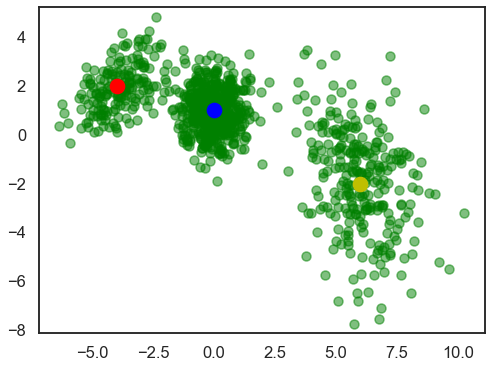

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(mus[0, 0], mus[0, 1], c='r', s=200)
plt.scatter(mus[1, 0], mus[1, 1], c='b', s=200)
plt.scatter(mus[2, 0], mus[2, 1], c='y', s=200)
#plot_ellipse(ax,mus,sigmas)
ax.axis('equal')
plt.show()

In [17]:
## Build model and sample
# Number of iterations for sampler
draws = 2000
# Prepare lists of starting points for mu to prevent label-switching problem
testvals = [[-2,-2],[0,0],[2,2]]

In [29]:
# Model structure
with pm.Model() as model:
    
    # Prior over component weights
    p = pm.Dirichlet('p', a=np.array([1.]*K))
    
    # Prior over component means
    mus = [pm.MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(D)), tau=pm.floatX(0.1 * np.eye(D)), shape=(D,), testval=pm.floatX(testvals[i])) for i in range(K)]
    
    # Cholesky decomposed LKJ prior over component covariance matrices
    packed_L = [pm.LKJCholeskyCov('packed_L_%d' % i, n=D, eta=2., sd_dist=pm.HalfCauchy.dist(1)) for i in range(K)]
    
    #Unpack packed_L into full array
    L = [pm.expand_packed_triangular(D, packed_L[i]) for i in range(K)]
    
    # Convert L to sigma and tau for convenience
    sigma = [pm.Deterministic('sigma_%d' % i ,L[i].dot(L[i].T)) for i in range(K)]
    
    tau = [pm.Deterministic('tau_%d' % i,matrix_inverse(sigma[i])) for i in range(K)]
    
    # Specify the likelihood
    mvnl = [pm.MvNormal.dist(mu=mus[i],chol=L[i]) for i in range(K)]
    Y_obs = pm.Mixture('Y_obs',w=p, comp_dists=mvnl,observed=data)
    


In [30]:
with model:
    step = pm.NUTS()
    trace = pm.sample(draws=2000, tune=2000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_L_2, packed_L_1, packed_L_0, mu_2, mu_1, mu_0, p]
Sampling 2 chains, 0 divergences:   0%|          | 0/8000 [12:33<?, ?draws/s]


ValueError: Not enough samples to build a trace.

In [ ]:
## Plot traces
pm.traceplot(trace)
plt.show()